In [1]:
from Inverse import *
from q_method import *

In [2]:
N = 64
k = [20]
m = 64
maxq = 0.1
q_method = 'G'
noise_level = 0.0
gtol = 1e-10
maxiter = 20

In [3]:
sys.path.append('/data/liuziyang/Programs/pde_solver')
if isinstance(k,str):
    tmp_k = k.split(',')
    k = [float(eval(item)) for item in tmp_k]
k_len = len(k)
NET = torch.load('/data/liuziyang/Programs/pde_solver/Network/k20_P_4,64,uniform_G_0.1_NST_R200_12,32,4_1.pth')
q = q_gen(N, q_method, maxq)
Q = q.reshape(-1, )
Q0 = Q*0
matrix_A = gen_A(N)
Matrix_analysis(N)
f_data = np.zeros((k_len,m,(N+1)**2),dtype = np.complex128)
partial_data = np.zeros((k_len,m,4*N-4),dtype = np.complex128)
for j in range(k_len):
    f_data[j] = f_gen(N, k[j], m)
    partial_data[j] = pdata_gen(N, Q, k[j], f_data[j], matrix_A,noise_level)

f_data_torch = torch.stack([torch.from_numpy(f_data.reshape(k_len,m,(N+1),(N+1)).real).to(torch.float32).to(device),
                           torch.from_numpy(f_data.reshape(k_len,m,(N+1),(N+1)).imag).to(torch.float32).to(device)],2)
partial_data_torch = torch.stack([torch.from_numpy(partial_data.reshape(k_len,m,4*N-4).real).to(torch.float32).to(device),
                           torch.from_numpy(partial_data.reshape(k_len,m,4*N-4).imag).to(torch.float32).to(device)],2)
matrix_A_torch = torch.from_numpy(matrix_A).to(torch.float32).to(device)
matrix_A_torch = matrix_A_torch.unsqueeze(0).unsqueeze(1).repeat(m,2,1,1)
f_data = (f_data, f_data_torch)
partial_data = (partial_data,partial_data_torch)
matrix_A = (matrix_A,matrix_A_torch)

CPU times: user 2min 15s, sys: 3.89 s, total: 2min 19s
Wall time: 4.37 s
CPU times: user 4.94 s, sys: 194 ms, total: 5.13 s
Wall time: 251 ms
MUMPS: 0.0
NET:   9.873698202144613e-05
相对误差为inf%


/data/liuziyang/Programs/pde_solver/src/utils.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  rel_err = 100*(np.linalg.norm(data3)/np.linalg.norm(data1))


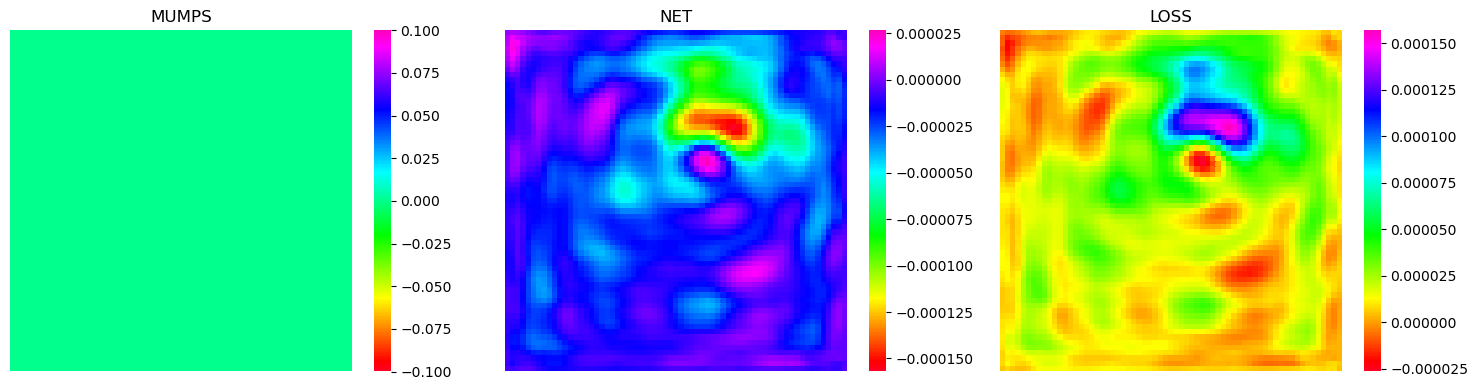

In [4]:
%time data_np = J_MUMPS(Q,N,partial_data[0][0],k[0],f_data[0][0],matrix_A[0])
%time data_torch = J_NET(Q,N,partial_data[1][0],k[0],f_data[1][0],matrix_A[1],NET,device,3)
print('MUMPS: {}'.format(data_np[0]))
print('NET:   {}'.format(data_torch[0]))
heatmap_for_test(data_np[1].reshape(65,65),data_torch[1].reshape(65,65),['MUMPS','NET','LOSS'],loss = True)